<a href="https://colab.research.google.com/github/okok7272/CodeStatesProject/blob/main/DAICONshoppingMall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install scikit-learn==0.24.2
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.3 MB 1.6 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.2 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.2 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import seaborn as sns

# DAICON 쇼핑몰 지점별 매출액 예측 경진대회

발표자 강인구 

#1. EDA

In [17]:
target='Weekly_Sales'
sample_submission = pd.read_csv('/content/drive/MyDrive/Dataset/sample_submission.csv')
train = pd.read_csv('/content/drive/MyDrive/Dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Dataset/test.csv')

In [18]:
train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


In [19]:
train.isnull().sum()

id                 0
Store              0
Date               0
Temperature        0
Fuel_Price         0
Promotion1      4153
Promotion2      4663
Promotion3      4370
Promotion4      4436
Promotion5      4140
Unemployment       0
IsHoliday          0
Weekly_Sales       0
dtype: int64

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   Promotion1    2102 non-null   float64
 6   Promotion2    1592 non-null   float64
 7   Promotion3    1885 non-null   float64
 8   Promotion4    1819 non-null   float64
 9   Promotion5    2115 non-null   float64
 10  Unemployment  6255 non-null   float64
 11  IsHoliday     6255 non-null   bool   
 12  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 592.6+ KB


Promotion 같은 경우 행사에 따른 정보로 float 형태인 것을 보아 데이터 값이 행사로 인한 판매량이나 판매금액 또는 퍼센트를 알려주는 것인 것을 알 수 있다.

In [21]:
train=train.fillna(0)
test=test.fillna(0)
sample_submission=sample_submission.fillna(0)

In [22]:
sample_submission.head()

,id,Weekly_Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [9]:
train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,0.0,0.0,0.0,0.0,0.0,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,0.0,0.0,0.0,0.0,0.0,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,0.0,0.0,0.0,0.0,0.0,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,0.0,0.0,0.0,0.0,0.0,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,0.0,0.0,0.0,0.0,0.0,8.106,False,1554806.68


#**해당 dataset분석**

##1. train.csv : 학습 데이터

*  id : 샘플 아이디

*  Store : 쇼핑몰 지점

*  Date : 주 단위(Weekly) 날짜

*  Temperature : 해당 쇼핑몰 주변 기온(F)

*  Fuel_Price : 해당 쇼핑몰 주변 연료 가격

*  Promotion 1~5 : 해당 쇼핑몰의 비식별화된 프로모션 정보

*  Unemployment : 해당 쇼핑몰 지역의 실업률

*  IsHoliday : 해당 기간의 공휴일 포함 여부

*  Weekly_Sales : 주간 매출액 (목표 예측값)


##2. test.csv : 테스트 데이터

*  id : 샘플 아이디

*  Store : 쇼핑몰 지점

*  Date : 주 단위(Weekly) 날짜

*  Temperature : 해당 쇼핑몰 주변 기온(F)

*  Fuel_Price : 해당 쇼핑몰 주변 연료 가격

*  Promotion 1~5 : 해당 쇼핑몰의 비식별화된 프로모션 정보

*  Unemployment : 해당 쇼핑몰 지역의 실업률

*  IsHoliday : 해당 기간의 공휴일 포함 여부

##3. Target : Weekly_Sales 


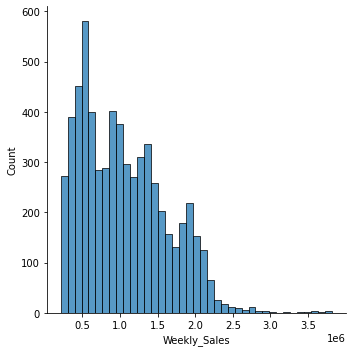

In [23]:
sns.displot(train['Weekly_Sales']);

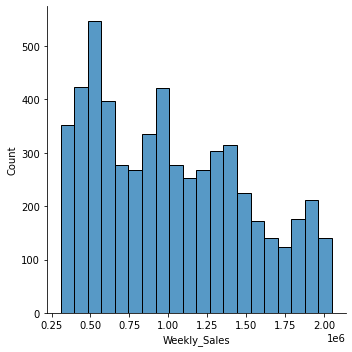

In [24]:
cond1 = train['Weekly_Sales']>=np.percentile(train['Weekly_Sales'],5)
cond2 = train['Weekly_Sales']<=np.percentile(train['Weekly_Sales'],95)

train= train[(cond1 & cond2)]
sns.displot(train['Weekly_Sales'])

In [14]:
train.shape

(5629, 13)

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5629 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            5629 non-null   int64  
 1   Store         5629 non-null   int64  
 2   Date          5629 non-null   object 
 3   Temperature   5629 non-null   float64
 4   Fuel_Price    5629 non-null   float64
 5   Promotion1    5629 non-null   float64
 6   Promotion2    5629 non-null   float64
 7   Promotion3    5629 non-null   float64
 8   Promotion4    5629 non-null   float64
 9   Promotion5    5629 non-null   float64
 10  Unemployment  5629 non-null   float64
 11  IsHoliday     5629 non-null   bool   
 12  Weekly_Sales  5629 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 577.2+ KB


In [28]:
from sklearn.feature_selection import f_regression, SelectKBest
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=0.80, test_size=0.20, random_state=2)


In [29]:
train['Date']= pd.to_datetime(train['Date'], format="%d/%m/%Y")
val['Date']= pd.to_datetime(val['Date'], format="%d/%m/%Y")

test['Date']= pd.to_datetime(test['Date'], format="%d/%m/%Y")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
train['Date']

2074   2012-07-20
5305   2010-07-16
5040   2010-10-15
3682   2011-05-27
1200   2011-10-14
          ...    
3705   2011-11-04
1269   2010-06-11
2868   2011-10-14
3980   2011-10-14
2929   2010-04-16
Name: Date, Length: 4503, dtype: datetime64[ns]

In [31]:
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score